In [1]:
import numpy as np
import pandas as pd

from src.data_exploration import *
from src.visualization import *

#  Loading Data & Adding Relevant Fields

We load in the data and add the following columns:
* `test_acc_drop`: the drop in test accuracy between the SIGMORPHON 2020 split and the Goldman et al. split for each language

* `Goldman_seen_lemmas`: the number of lemmas that were seen in either `train` or `dev` in the Goldman et al. data, which can be calculated straightforwardly by adding the number of lemmas in `train+dev` since we know those sets are disjoint for the Goldman data

* `train_lemma_diff_raw`, `seen_lemma_diff_raw`, and `train_size_diff_raw`: the raw differences between the SIGMORPHON 2020 and Goldman et al training data in terms of number of lemmas in `train`, number of lemmas in `train+dev`, and overall training size

*  `train_lemma_diff_scaled`, `seen_lemma_diff_scaled`, and `train_size_diff_scaled`: the scaled difference (calculated as percent difference) between the SIGMORPHON 2020 and Goldman et al training data in terms of number of lemmas in `train`, number of lemmas in `train+dev`, and overall training size



In [3]:
# Read in the data and force the data types 
replication = pd.read_csv("replication/replication.tsv", sep='\t').dropna()
replication['SIGMORPHON_train_size'] = replication['SIGMORPHON_train_size'].astype(float)

# The drop in performance between SIGMORPHON 2020 and Goldman et al.
replication["test_acc_drop"] = replication["Goldman_test_acc"] - replication["SIGMORPHON_test_acc"]

# Since the lemmas in the Goldman train + dev are disjoint, we can just add them to get the total number of seen lemmas
replication["Goldman_seen_lemmas"] = replication["Goldman_train_lemmas"] + replication["Goldman_dev_lemmas"]

# Get the train lemma difference and scale it 
replication["train_lemma_diff_raw"] = replication["Goldman_train_lemmas"] - replication["SIGMORPHON_train_lemmas"]
replication["train_lemma_diff_scaled"] = 100* replication["train_lemma_diff_raw"] / replication["SIGMORPHON_train_lemmas"]

# Get the seen lemma difference and scale it 
replication["seen_lemma_diff_raw"] = replication["Goldman_seen_lemmas"] - replication["SIGMORPHON_seen_lemmas"]
replication["seen_lemma_diff_scaled"] = 100* replication["seen_lemma_diff_raw"] / replication["SIGMORPHON_seen_lemmas"]

# Get the train size difference and scale it
replication["train_size_diff_raw"] = replication["Goldman_train_size"] - replication["SIGMORPHON_train_size"] 
replication["train_size_diff_scaled"] = 100* replication["train_size_diff_raw"] / replication["SIGMORPHON_train_size"]

# Preview the dataframe
replication

,Family,Language,SIGMORPHON_dev_acc,SIGMORPHON_test_acc,Goldman_dev_acc,Goldman_test_acc,SIGMORPHON_train_size,Goldman_train_size,SIGMORPHON_dev_size,Goldman_dev_size,...,Goldman_dev_lemmas,Goldman_test_lemmas,test_acc_drop,Goldman_seen_lemmas,train_lemma_diff_raw,train_lemma_diff_scaled,seen_lemma_diff_raw,seen_lemma_diff_scaled,train_size_diff_raw,train_size_diff_scaled
0,niger_congo,aka,100.0000,100.0000,39.7500,30.0385,2793.0,2747.0,380.0,410.0,...,10.0,19.0,-69.9615,77.0,-29.0,-30.208333,-19.0,-19.791667,-46.0,-1.646975
1,niger_congo,gaa,100.0000,99.4083,71.1111,53.2164,607.0,594.0,79.0,90.0,...,10.0,19.0,-46.1919,76.0,-29.0,-30.526316,-19.0,-20.000000,-13.0,-2.141680
2,niger_congo,kon,100.0000,98.0769,85.0000,88.1250,568.0,560.0,76.0,80.0,...,20.0,40.0,-9.9519,160.0,-59.0,-29.648241,-40.0,-20.000000,-8.0,-1.408451
3,niger_congo,lin,100.0000,100.0000,83.3333,56.2500,159.0,156.0,23.0,24.0,...,6.0,12.0,-43.7500,45.0,-18.0,-31.578947,-12.0,-21.052632,-3.0,-1.886792
4,niger_congo,lug,93.6605,90.5834,51.2552,18.5610,3420.0,3300.0,489.0,478.0,...,9.0,18.0,-72.0224,71.0,-27.0,-30.337079,-18.0,-20.224719,-120.0,-3.508772
5,niger_congo,nya,100.0000,100.0000,90.6178,75.8581,3031.0,3002.0,429.0,437.0,...,23.0,46.0,-24.1419,181.0,-69.0,-30.396476,-46.0,-20.264317,-29.0,-0.956780
6,niger_congo,sna,100.0000,100.0000,71.1111,26.2745,1897.0,1800.0,246.0,270.0,...,9.0,17.0,-73.7255,69.0,-26.0,-30.232558,-17.0,-19.767442,-97.0,-5.113337
7,niger_congo,sot,100.0000,97.9798,0.0000,0.0000,345.0,342.0,50.0,57.0,...,3.0,5.0,-97.9798,21.0,-8.0,-30.769231,-5.0,-19.230769,-3.0,-0.869565
8,niger_congo,swa,100.0000,100.0000,58.9796,42.9592,3374.0,3283.0,469.0,490.0,...,10.0,20.0,-57.0408,77.0,-30.0,-30.927835,-20.0,-20.618557,-91.0,-2.697095
9,niger_congo,zul,85.7143,92.3077,36.9565,32.2222,322.0,300.0,42.0,46.0,...,9.0,18.0,-60.0855,69.0,-27.0,-31.034483,-18.0,-20.689655,-22.0,-6.832298


# The Role of Training Size

## Initial Replication: Training Size vs. Test Accuracy Drop

This section simply looks at the relationship between training size and test accuracy drop to re-create the plots in Goldman et al. 2022.
Though there is clearly an overall effect of training size on the performance drop, it seems that this effect only really appears when larger training sizes are included, as we can see when we consider Niger-Congo and Uralic families separately.

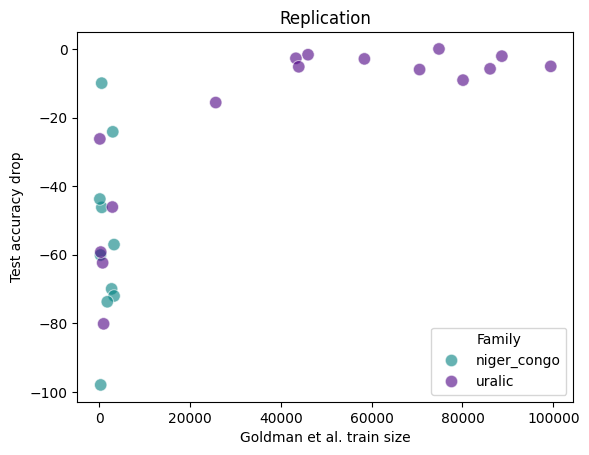

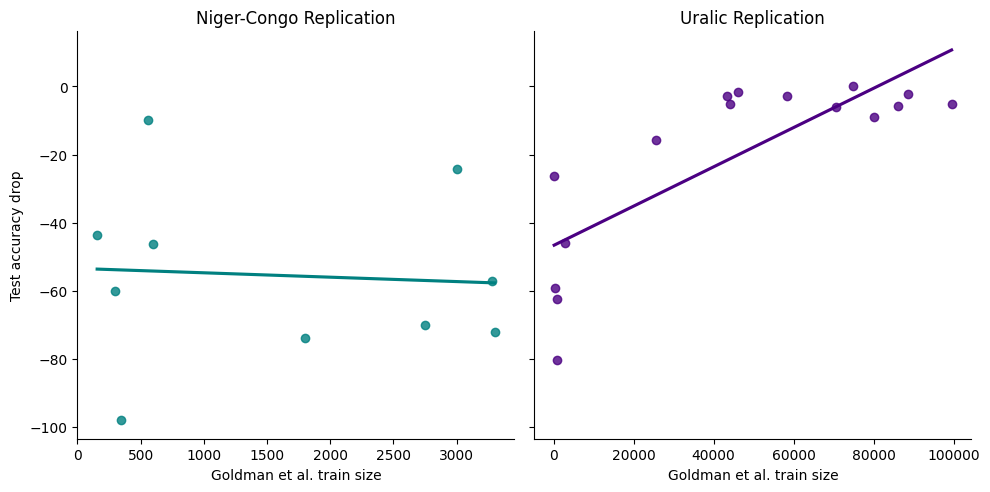

-------------------
All Families:
-------------------
Pearson's R:	0.757,	 p = 7.4972239191972325e-06
Spearman:	0.704,	 p = 6.000973238503066e-05
Kendall's Tau:	0.477,	 p = 0.0004474231160704783

-------------------
Niger-Congo:
-------------------
Pearson's R:	-0.068,	 p = 0.8519813936265076
Spearman:	-0.127,	 p = 0.7260570147627894
Kendall's Tau:	-0.111,	 p = 0.7274895282186948

-------------------
Uralic:
-------------------
Pearson's R:	0.795,	 p = 0.0002295022527005793
Spearman:	0.676,	 p = 0.00400825239020936
Kendall's Tau:	0.467,	 p = 0.011480597067017682


In [4]:
# Training size vs. test accuracy drop
run_plotting(replication, 
             "Goldman_train_size", 
             "test_acc_drop",
             xlabel="Goldman et al. train size",
             ylabel="Test accuracy drop",
             title="Replication"
            )

## Raw Training Size Drop vs. Test Accuracy Drop


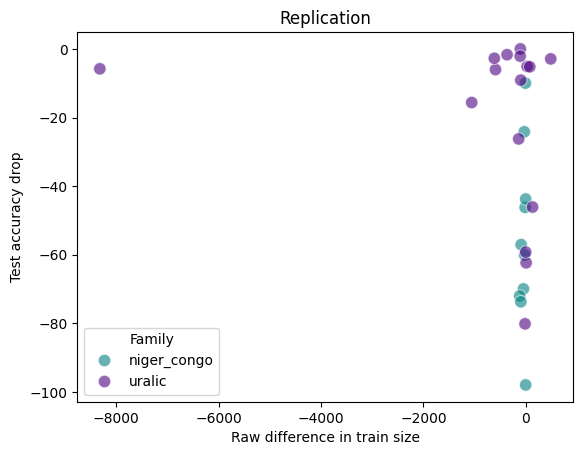

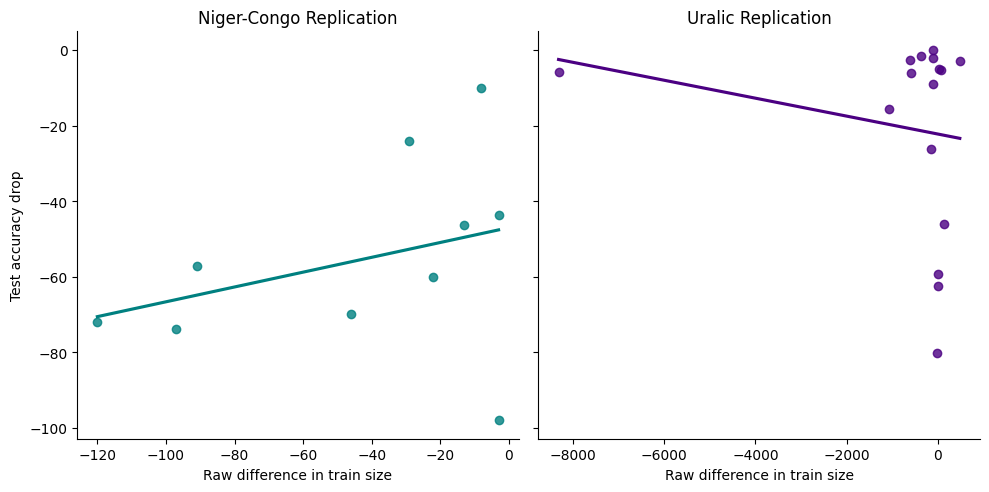

-------------------
All Families:
-------------------
Pearson's R:	-0.225,	 p = 0.26869796307523824
Spearman:	-0.247,	 p = 0.2240369624900194
Kendall's Tau:	-0.154,	 p = 0.27031156226812647

-------------------
Niger-Congo:
-------------------
Pearson's R:	0.334,	 p = 0.34604208041322776
Spearman:	0.340,	 p = 0.3357822630985314
Kendall's Tau:	0.315,	 p = 0.2086677876982641

-------------------
Uralic:
-------------------
Pearson's R:	-0.187,	 p = 0.48697147271924807
Spearman:	-0.200,	 p = 0.45768790507519985
Kendall's Tau:	-0.117,	 p = 0.5642673786464399


In [4]:
# Training size drop vs. test accuracy drop with all the data 
run_plotting(replication, 
             "train_size_diff_raw", 
             "test_acc_drop",
             xlabel="Raw difference in train size",
             ylabel="Test accuracy drop",
             title="Replication"
            )

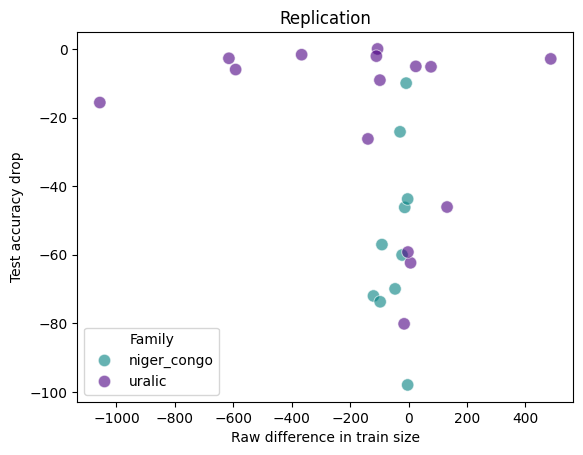

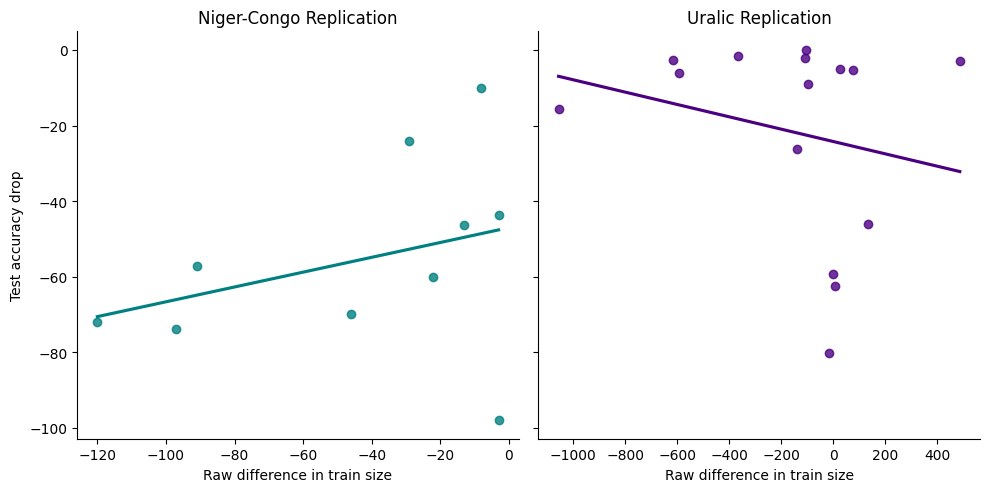

-------------------
All Families:
-------------------
Pearson's R:	-0.239,	 p = 0.2497102793675735
Spearman:	-0.223,	 p = 0.28454008933223596
Kendall's Tau:	-0.130,	 p = 0.3622467546490362

-------------------
Niger-Congo:
-------------------
Pearson's R:	0.334,	 p = 0.34604208041322776
Spearman:	0.340,	 p = 0.3357822630985314
Kendall's Tau:	0.315,	 p = 0.2086677876982641

-------------------
Uralic:
-------------------
Pearson's R:	-0.225,	 p = 0.4190828482222893
Spearman:	-0.239,	 p = 0.39037931192023567
Kendall's Tau:	-0.124,	 p = 0.5589660721223221


In [5]:
# Training size drop vs. test accuracy drop with the outlier dropped 
run_plotting(replication.query("train_size_diff_raw > -4000"), 
             "train_size_diff_raw", 
             "test_acc_drop",
             xlabel="Raw difference in train size",
             ylabel="Test accuracy drop",
             title="Replication"
            )

## Scaled Difference in Training Size vs. Test Accuracy Drop

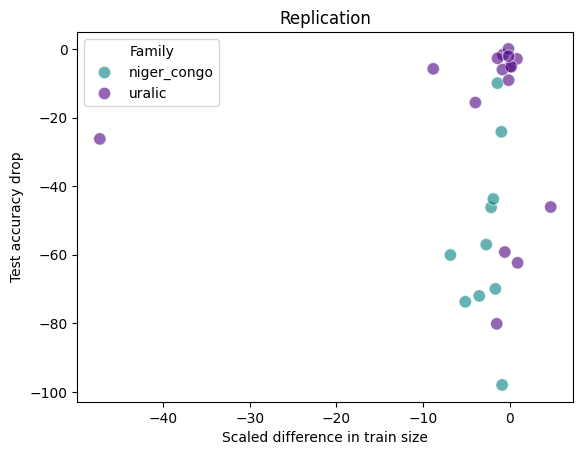

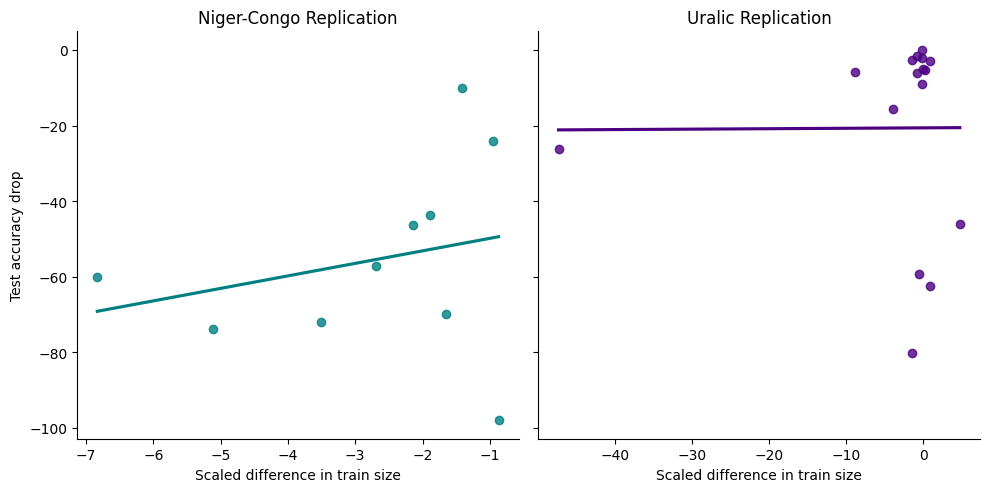

-------------------
All Families:
-------------------
Pearson's R:	-0.010,	 p = 0.9612289687161129
Spearman:	0.372,	 p = 0.06158029079877183
Kendall's Tau:	0.243,	 p = 0.08558212104491403

-------------------
Niger-Congo:
-------------------
Pearson's R:	0.250,	 p = 0.48664007594829006
Spearman:	0.261,	 p = 0.4670890543863402
Kendall's Tau:	0.289,	 p = 0.2912483465608466

-------------------
Uralic:
-------------------
Pearson's R:	0.005,	 p = 0.9847408674457516
Spearman:	0.047,	 p = 0.8626036946668731
Kendall's Tau:	0.033,	 p = 0.8943512599699821


In [5]:
# Scaled difference in training size vs. test accuracy drop for all languages 
run_plotting(replication, 
             "train_size_diff_scaled", 
             "test_acc_drop",
             xlabel="Scaled difference in train size",
             ylabel="Test accuracy drop",
             title="Replication"
            )

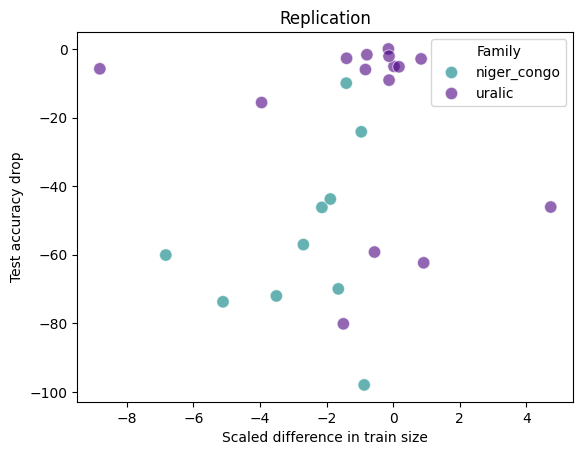

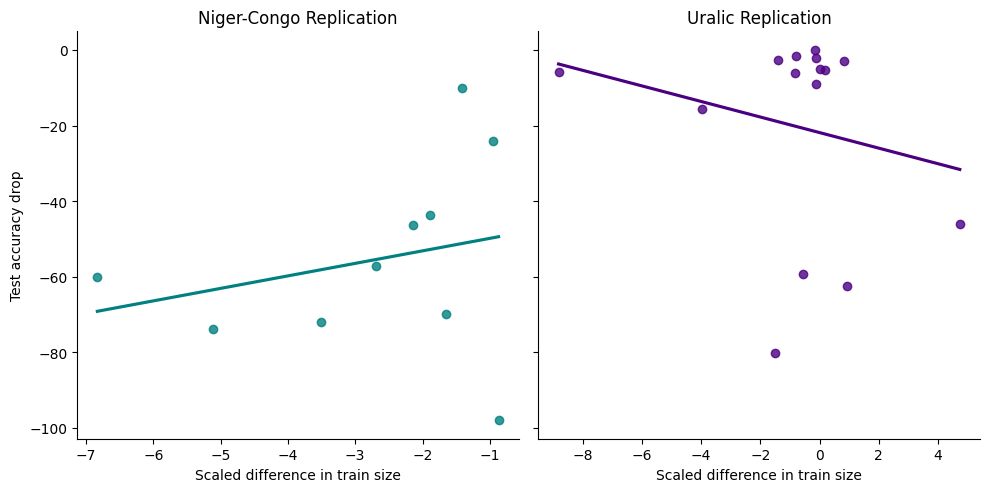

-------------------
All Families:
-------------------
Pearson's R:	0.142,	 p = 0.4978641741866947
Spearman:	0.393,	 p = 0.05191625841542359
Kendall's Tau:	0.260,	 p = 0.07183422315251489

-------------------
Niger-Congo:
-------------------
Pearson's R:	0.250,	 p = 0.48664007594829006
Spearman:	0.261,	 p = 0.4670890543863402
Kendall's Tau:	0.289,	 p = 0.2912483465608466

-------------------
Uralic:
-------------------
Pearson's R:	-0.217,	 p = 0.436250729651435
Spearman:	-0.018,	 p = 0.9496353041738621
Kendall's Tau:	-0.029,	 p = 0.9225700904951897


In [6]:
# Scaled difference in training size vs. test accuracy drop with outlier removed
run_plotting(replication.query("train_size_diff_scaled > -40"), 
             "train_size_diff_scaled", 
             "test_acc_drop",
             xlabel="Scaled difference in train size",
             ylabel="Test accuracy drop",
             title="Replication"
            )

# The Role of Training Lemmas
The nature of Goldman et al's sampling strategy means that we can expect overall _fewer_ lemmas in their training sets than in the SIGMORPHON ones, so we examine how this difference impacts the performance drop.

## Training Lemma Count 
We begin by examining the relationship between the number of lemmas in train and the performance drop. The overall relationship is similar to that for train size, but holds within both language groups.

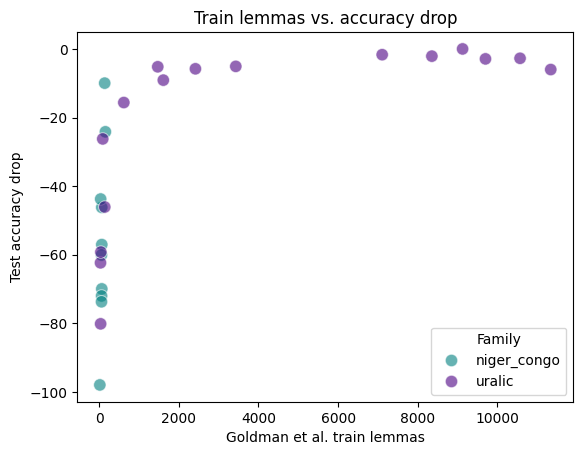

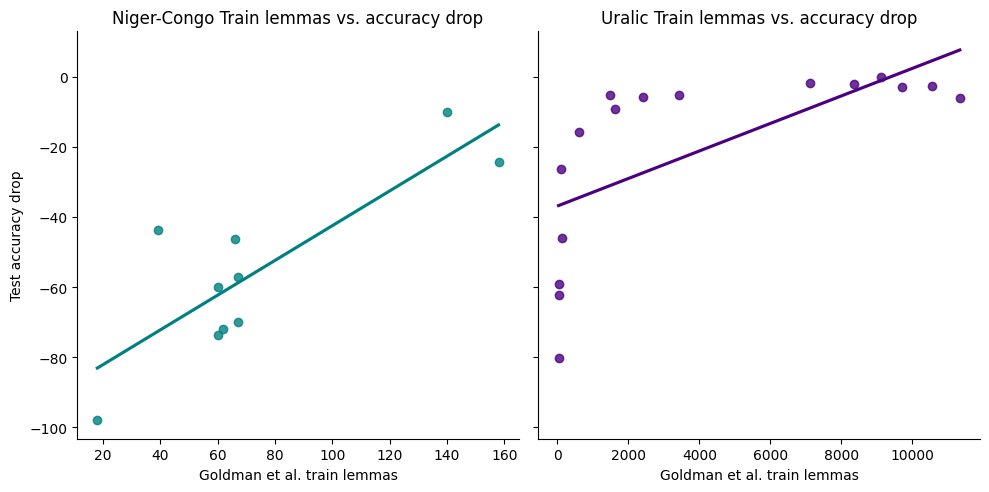

-------------------
All Families:
-------------------
Pearson's R:	0.662,	 p = 0.00023294543130992934
Spearman:	0.903,	 p = 2.927575535455259e-10
Kendall's Tau:	0.744,	 p = 1.0689401211483498e-07

-------------------
Niger-Congo:
-------------------
Pearson's R:	0.826,	 p = 0.003207316919283858
Spearman:	0.622,	 p = 0.05485939233686208
Kendall's Tau:	0.477,	 p = 0.058290580139488755

-------------------
Uralic:
-------------------
Pearson's R:	0.657,	 p = 0.005725574254936035
Spearman:	0.829,	 p = 7.088454064639912e-05
Kendall's Tau:	0.683,	 p = 8.266191981366419e-05


In [7]:
# Training lemma count vs. test accuracy drop
run_plotting(replication, 
             "Goldman_train_lemmas", 
             "test_acc_drop",
             xlabel="Goldman et al. train lemmas",
             ylabel="Test accuracy drop",
             title="Train lemmas vs. accuracy drop"
            )

## Raw Difference in Number of Training Lemmas

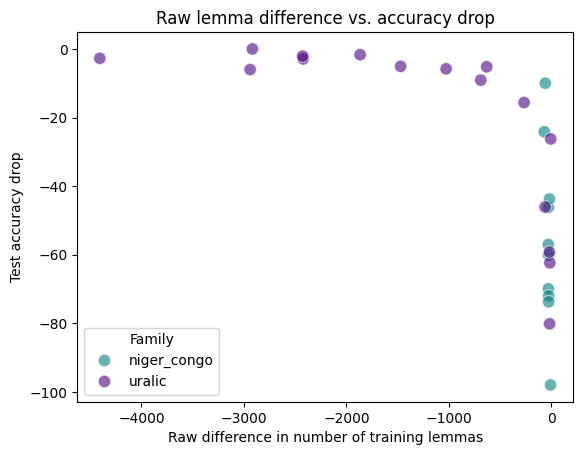

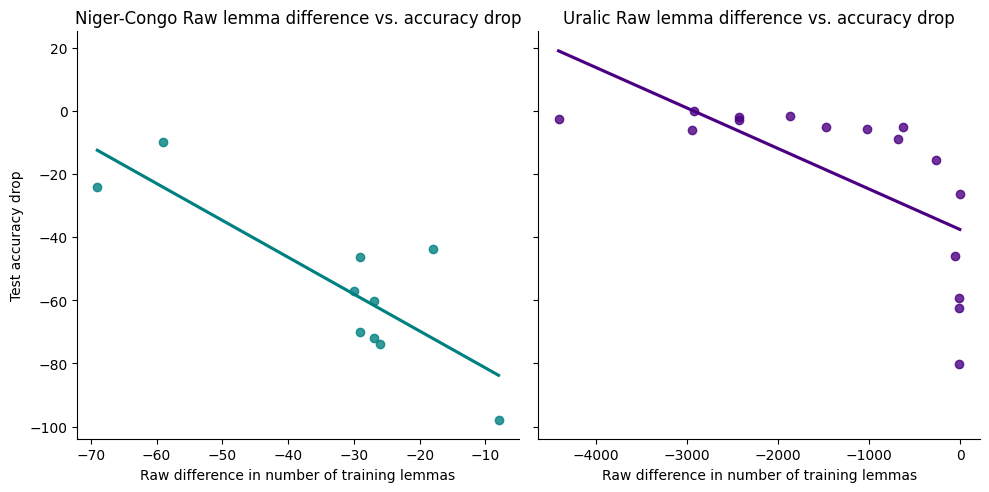

-------------------
All Families:
-------------------
Pearson's R:	-0.672,	 p = 0.00016992111017554982
Spearman:	-0.864,	 p = 1.3474464364268611e-08
Kendall's Tau:	-0.707,	 p = 4.418814332605344e-07

-------------------
Niger-Congo:
-------------------
Pearson's R:	-0.828,	 p = 0.0030830571342569586
Spearman:	-0.683,	 p = 0.0295125778506635
Kendall's Tau:	-0.568,	 p = 0.024185218322711265

-------------------
Uralic:
-------------------
Pearson's R:	-0.669,	 p = 0.004580224139753578
Spearman:	-0.835,	 p = 5.637132062814425e-05
Kendall's Tau:	-0.683,	 p = 8.266191981366419e-05


In [8]:
# Raw difference in number of training lemmas between SIGMORPHON and Goldman
run_plotting(replication, 
             "train_lemma_diff_raw", 
             "test_acc_drop",
             xlabel="Raw difference in number of training lemmas",
             ylabel="Test accuracy drop",
             title="Raw lemma difference vs. accuracy drop"
            )

## Scaled Difference in Number of Training Lemmas

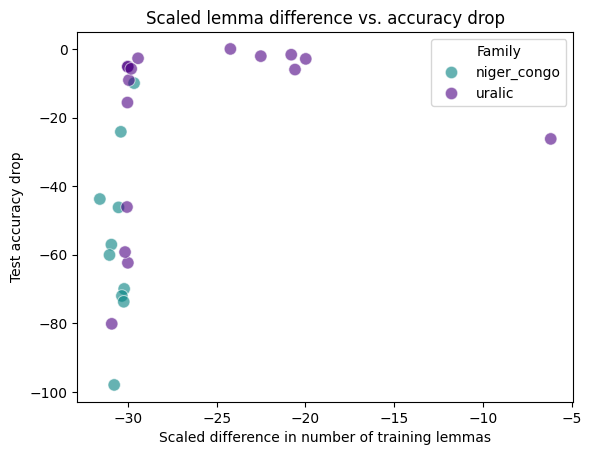

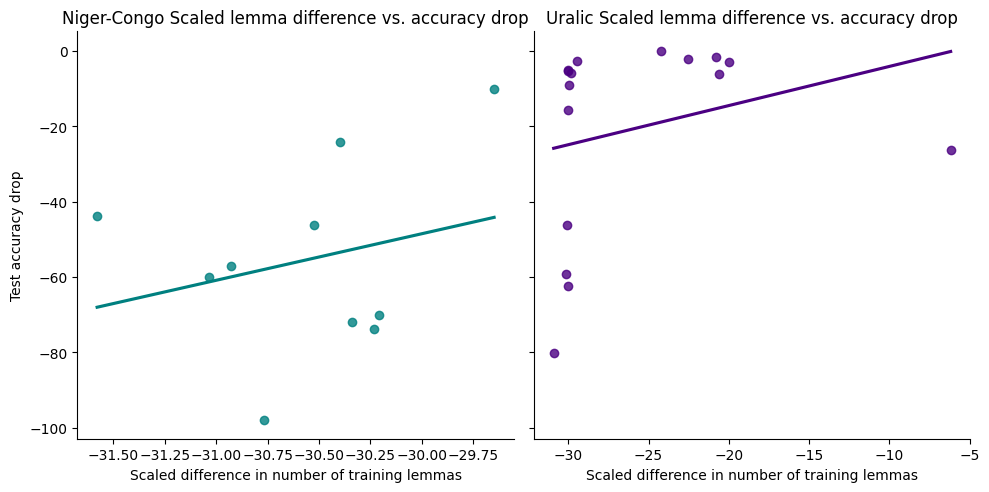

-------------------
All Families:
-------------------
Pearson's R:	0.395,	 p = 0.04581338094089396
Spearman:	0.727,	 p = 2.572669985707369e-05
Kendall's Tau:	0.526,	 p = 8.9175233222817e-05

-------------------
Niger-Congo:
-------------------
Pearson's R:	0.258,	 p = 0.47196855757315487
Spearman:	-0.006,	 p = 0.9867429111949892
Kendall's Tau:	0.022,	 p = 1.0

-------------------
Uralic:
-------------------
Pearson's R:	0.264,	 p = 0.32338126600280653
Spearman:	0.571,	 p = 0.020990696368217765
Kendall's Tau:	0.433,	 p = 0.019780631759408317


In [8]:
# Percent difference in training lemmas between SIGMORPHON and Goldman et al.
run_plotting(replication, 
             "train_lemma_diff_scaled", 
             "test_acc_drop",
             xlabel="Scaled difference in number of training lemmas",
             ylabel="Test accuracy drop",
             title="Scaled lemma difference vs. accuracy drop"
            )

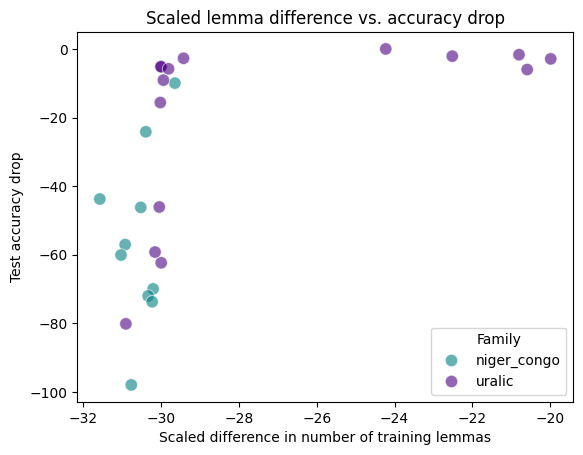

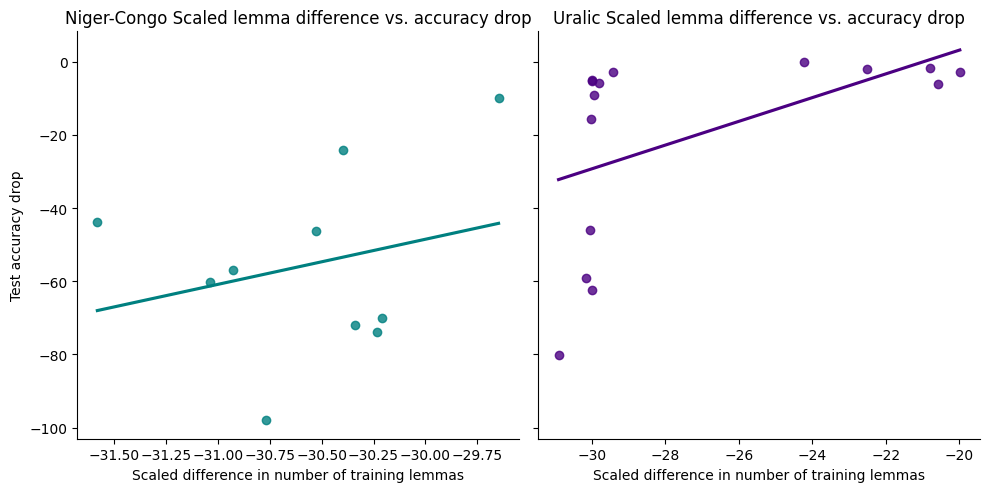

-------------------
All Families:
-------------------
Pearson's R:	0.563,	 p = 0.0033802453954751275
Spearman:	0.770,	 p = 6.7635213040788544e-06
Kendall's Tau:	0.573,	 p = 2.3964390237921895e-05

-------------------
Niger-Congo:
-------------------
Pearson's R:	0.258,	 p = 0.47196855757315487
Spearman:	-0.006,	 p = 0.9867429111949892
Kendall's Tau:	0.022,	 p = 1.0

-------------------
Uralic:
-------------------
Pearson's R:	0.505,	 p = 0.05474893240833616
Spearman:	0.725,	 p = 0.0022270323137542148
Kendall's Tau:	0.562,	 p = 0.0028582293753424705


In [12]:
# Percent difference in training lemmas between SIGMORPHON and Goldman et al., excluding outlier 
run_plotting(replication.query("train_lemma_diff_scaled < -10"), 
             "train_lemma_diff_scaled", 
             "test_acc_drop",
             xlabel="Scaled difference in number of training lemmas",
             ylabel="Test accuracy drop",
             title="Scaled lemma difference vs. accuracy drop"
            )

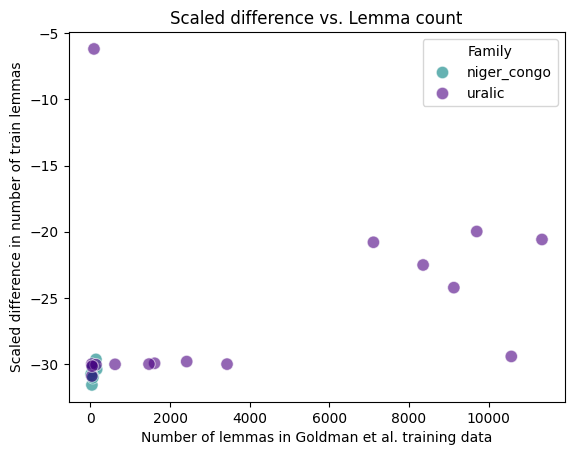

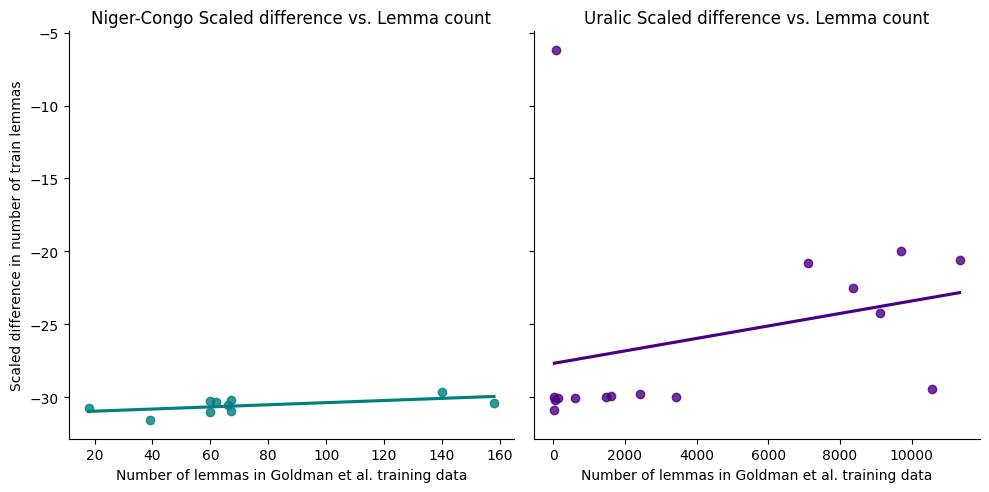

-------------------
All Families:
-------------------
Pearson's R:	0.429,	 p = 0.028674919430059162
Spearman:	0.747,	 p = 1.1527960667709856e-05
Kendall's Tau:	0.565,	 p = 5.44710882603799e-05

-------------------
Niger-Congo:
-------------------
Pearson's R:	0.584,	 p = 0.07605818711785683
Spearman:	0.530,	 p = 0.11467188344055661
Kendall's Tau:	0.386,	 p = 0.12531568180831723

-------------------
Uralic:
-------------------
Pearson's R:	0.282,	 p = 0.2904778765382495
Spearman:	0.626,	 p = 0.009413977306783637
Kendall's Tau:	0.517,	 p = 0.004639144437791718


In [11]:
# Is there a relationship between scaled difference and train size?
run_plotting(replication, 
             "Goldman_train_lemmas", 
             "train_lemma_diff_scaled",
             xlabel="Number of lemmas in Goldman et al. training data",
             ylabel="Scaled difference in number of train lemmas",
             title="Scaled difference vs. Lemma count"
            )

# The Role of Seen Lemmas

## Seen Lemma Count
There's no difference when we look at raw seen lemma count than when we look at raw train lemma count since the two are directly related.

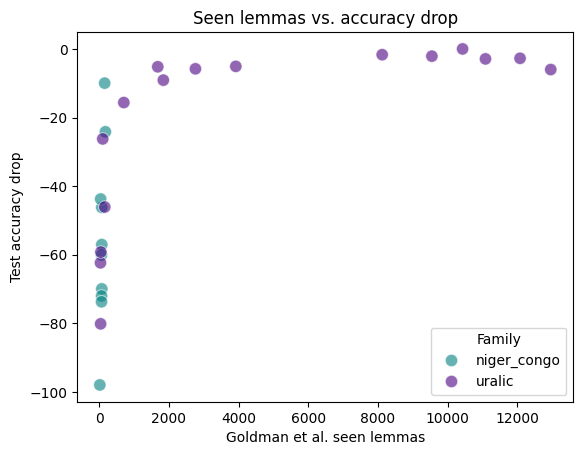

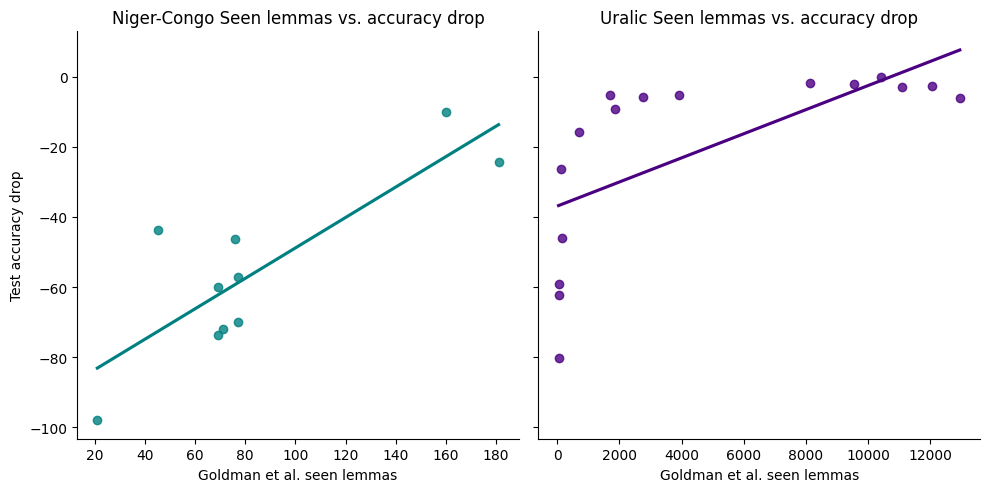

-------------------
All Families:
-------------------
Pearson's R:	0.662,	 p = 0.00023290829148344812
Spearman:	0.903,	 p = 2.927575535455259e-10
Kendall's Tau:	0.744,	 p = 1.0689401211483498e-07

-------------------
Niger-Congo:
-------------------
Pearson's R:	0.826,	 p = 0.003210636925641752
Spearman:	0.622,	 p = 0.05485939233686208
Kendall's Tau:	0.477,	 p = 0.058290580139488755

-------------------
Uralic:
-------------------
Pearson's R:	0.657,	 p = 0.005724593361385866
Spearman:	0.829,	 p = 7.088454064639912e-05
Kendall's Tau:	0.683,	 p = 8.266191981366419e-05


In [13]:
# Number of lemmas seen during train vs. test accuracy drop
run_plotting(replication, 
             "Goldman_seen_lemmas", 
             "test_acc_drop",
             xlabel="Goldman et al. seen lemmas",
             ylabel="Test accuracy drop",
             title="Seen lemmas vs. accuracy drop"
            )

## Raw Difference in Number of Seen Lemmas

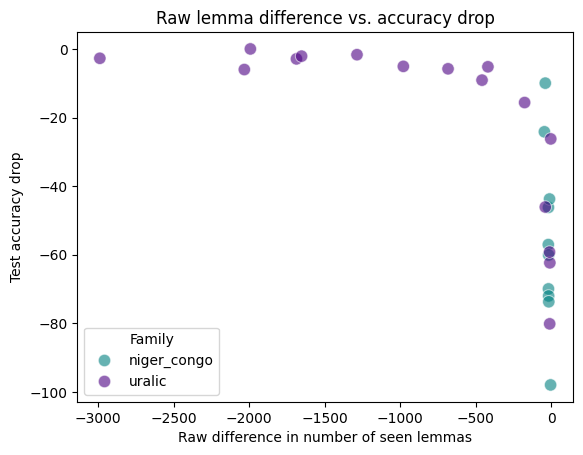

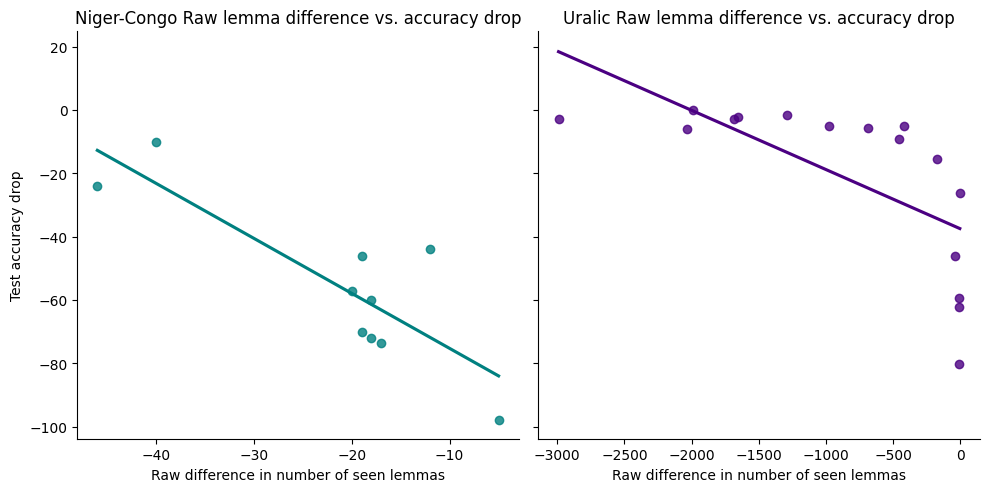

-------------------
All Families:
-------------------
Pearson's R:	-0.671,	 p = 0.00017781907875247748
Spearman:	-0.866,	 p = 1.1403066566898817e-08
Kendall's Tau:	-0.709,	 p = 4.3623167660595745e-07

-------------------
Niger-Congo:
-------------------
Pearson's R:	-0.834,	 p = 0.0027037326769178754
Spearman:	-0.683,	 p = 0.0295125778506635
Kendall's Tau:	-0.568,	 p = 0.024185218322711265

-------------------
Uralic:
-------------------
Pearson's R:	-0.667,	 p = 0.004738743252837703
Spearman:	-0.829,	 p = 7.088454064639912e-05
Kendall's Tau:	-0.667,	 p = 0.00013493716455180988


In [14]:
# Raw difference in number of seen lemmas between SIGMORPHON and Goldman et al
run_plotting(replication, 
             "seen_lemma_diff_raw", 
             "test_acc_drop",
             xlabel="Raw difference in number of seen lemmas",
             ylabel="Test accuracy drop",
             title="Raw lemma difference vs. accuracy drop"
            )

## Scaled Difference in Number of Seen Lemmas 

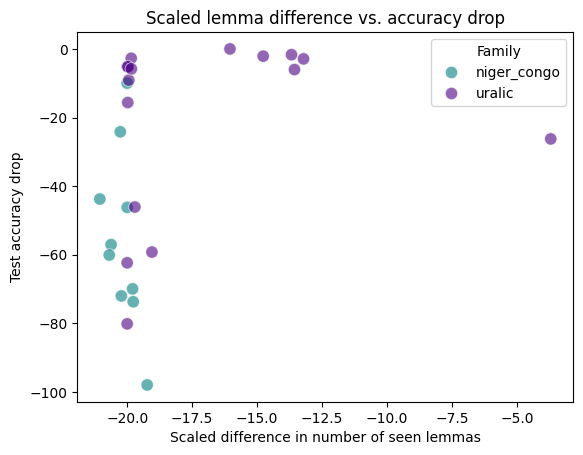

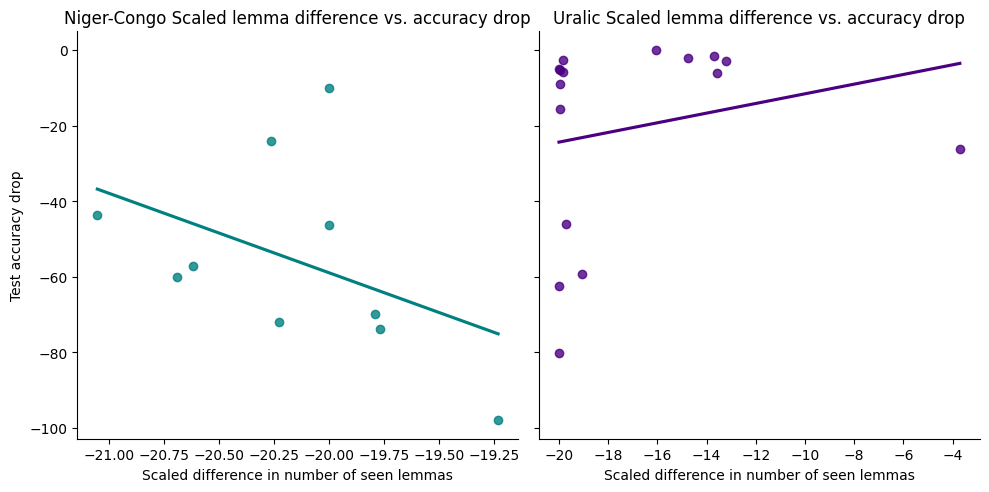

-------------------
All Families:
-------------------
Pearson's R:	0.339,	 p = 0.08997407733457527
Spearman:	0.387,	 p = 0.05058920332384321
Kendall's Tau:	0.258,	 p = 0.06675612807109482

-------------------
Niger-Congo:
-------------------
Pearson's R:	-0.433,	 p = 0.21169479387895346
Spearman:	-0.547,	 p = 0.1016780321289929
Kendall's Tau:	-0.405,	 p = 0.10599754842494571

-------------------
Uralic:
-------------------
Pearson's R:	0.219,	 p = 0.41613683899889464
Spearman:	0.405,	 p = 0.11996368646322479
Kendall's Tau:	0.259,	 p = 0.1623790710145101


In [20]:
# Scaled difference in the number of seen lemmas between SIGMORPHON and Goldman et al. 
run_plotting(replication, 
             "seen_lemma_diff_scaled", 
             "test_acc_drop",
             xlabel="Scaled difference in number of seen lemmas",
             ylabel="Test accuracy drop",
             title="Scaled lemma difference vs. accuracy drop"
            )

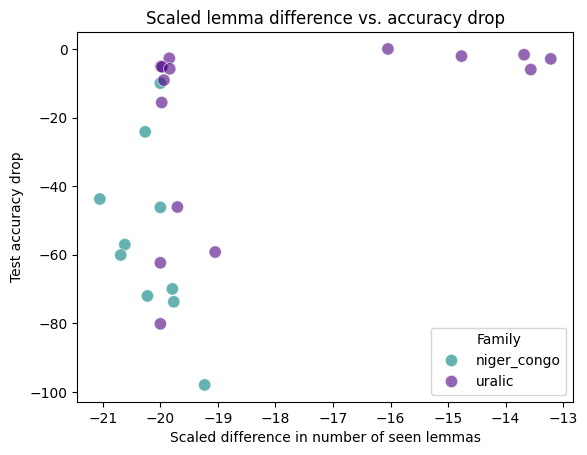

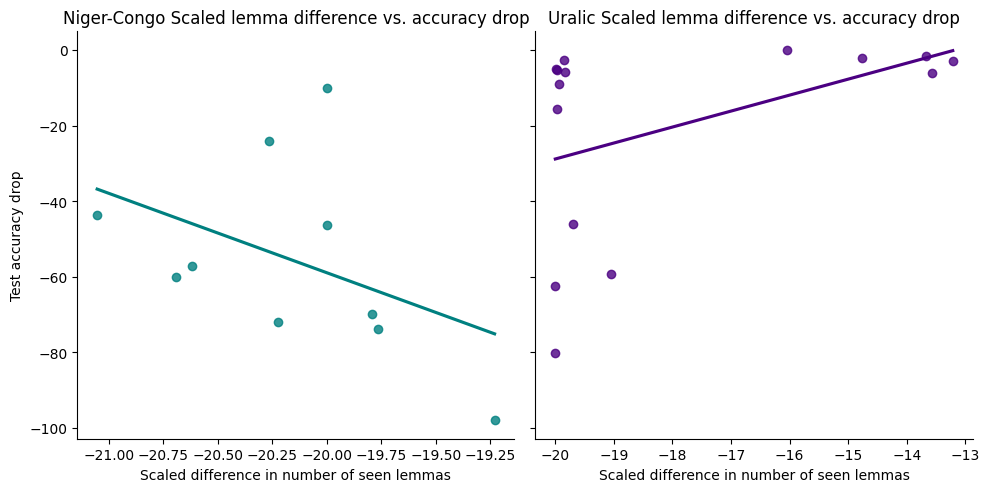

-------------------
All Families:
-------------------
Pearson's R:	0.479,	 p = 0.015415976065735238
Spearman:	0.416,	 p = 0.03871233057442882
Kendall's Tau:	0.283,	 p = 0.04924424431144538

-------------------
Niger-Congo:
-------------------
Pearson's R:	-0.433,	 p = 0.21169479387895346
Spearman:	-0.547,	 p = 0.1016780321289929
Kendall's Tau:	-0.405,	 p = 0.10599754842494571

-------------------
Uralic:
-------------------
Pearson's R:	0.437,	 p = 0.10307676033384135
Spearman:	0.556,	 p = 0.031434924726757546
Kendall's Tau:	0.364,	 p = 0.059724872589944966


In [15]:
# Scaled difference in the number of seen lemmas between SIGMORPHON and Goldman et al., excluding outlier 
run_plotting(replication.query("seen_lemma_diff_scaled < -6"), 
             "seen_lemma_diff_scaled", 
             "test_acc_drop",
             xlabel="Scaled difference in number of seen lemmas",
             ylabel="Test accuracy drop",
             title="Scaled lemma difference vs. accuracy drop"
            )

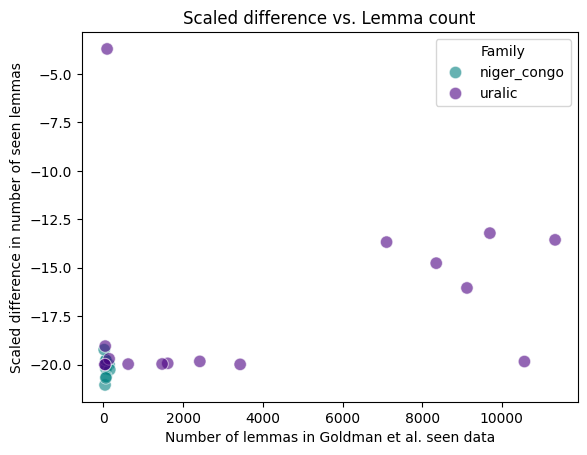

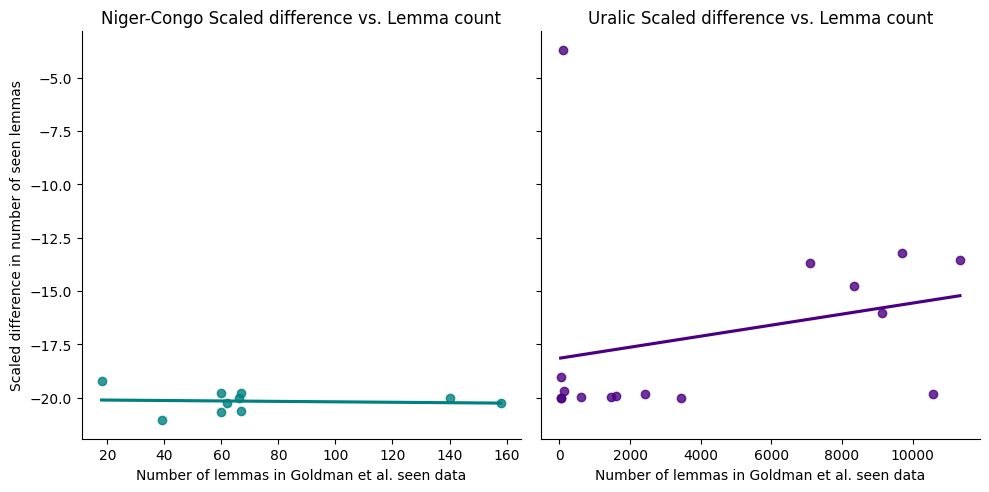

-------------------
All Families:
-------------------
Pearson's R:	0.403,	 p = 0.04099611447293068
Spearman:	0.478,	 p = 0.013616122117844088
Kendall's Tau:	0.352,	 p = 0.01251954437991079

-------------------
Niger-Congo:
-------------------
Pearson's R:	-0.083,	 p = 0.8186674921632837
Spearman:	-0.086,	 p = 0.814057586344012
Kendall's Tau:	-0.046,	 p = 0.8563373417080167

-------------------
Uralic:
-------------------
Pearson's R:	0.253,	 p = 0.3448940516288517
Spearman:	0.487,	 p = 0.055654436510311454
Kendall's Tau:	0.360,	 p = 0.052631355244461255


In [21]:
# Is there a relationship between scaled difference and train size?
run_plotting(replication, 
             "Goldman_train_lemmas", 
             "seen_lemma_diff_scaled",
             xlabel="Number of lemmas in Goldman et al. seen data",
             ylabel="Scaled difference in number of seen lemmas",
             title="Scaled difference vs. Lemma count"
            )